# Lab-10:  Advanced training of Neural Networks in Pytorch

You've already trained pretty efficient and precise neural networks. However, there are some methods that can make the training faster and more reliable. In this lab you're going to familiarize yourself with such techniques.


## Objectives:
Learn how to use:
1. Data augmentation; 
2. Batch normalization;
3. Dropout;
4. Early stopping;
5. Learning rate scheduling;
6. Tensorboard for training control.

# 1) Data augmentation
We're going to use a new dataset, CIFAR10, as our example for the task of classification. The data set consists of 60000 32x32 color images in 10 classes looking like this:

![example](https://pytorch.org/tutorials/_images/cifar10.png)

**Question: why might we use data augmentation? What problem does it solve?**

**Task 1.**

**1) Write the following augmentation transforms of CIFAR10 dataset:**

    - Crop (with size = 32, crop = 2) 
    - Horizontal flip (with probability 0.5)
    - Rotation (with 10 degrees max) 
    - Random affine (degrees = 0, shear = 10, scale=(0.8,1.2))
    
**2) Define DataLoader-s of CIFAR-10 with these transforms**

**Hint:** refer [ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) in Pytorch. 

In [3]:
from torch.utils import data
from torchvision import datasets, transforms

# You can increase these values if you've enough computational power
train_batch_size = 128
test_batch_size = 128


# Put augmentations
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Do not modify test transforms, because it will corrupt test data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# You should get how to get the training part of datasets.CIFAR10 and
# how to apply train_transforms here
# Specify path of downloaded set in root, if you've loaded it
train_dataset = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=train_transforms)

# Define the loader of train data set: use train_batch_size as batch_size
# and don't forget to shuffle
train_data_loader = data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


# Do the same for test part of CIFAR10, apply test_transforms
test_dataset = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=test_transforms)

# Define the loader of test data set: use test_batch_size
test_data_loader = data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

100%|██████████| 170M/170M [00:35<00:00, 4.78MB/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


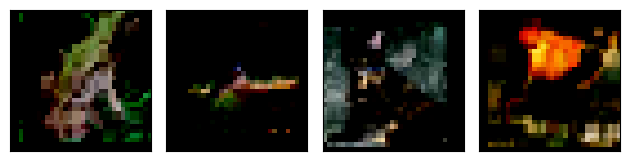

In [4]:
# Check the results of transformations
import matplotlib.pyplot as plt
images, _ = next(iter(train_data_loader))

fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(images[i].numpy().transpose(1,2,0))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
plt.tight_layout()
plt.show()

# 2) Build a model with dropout and batch normalization

Here we're going to build about the same model as we used before, but with two new layers: batch normalization and dropout.

**Question: what's the purpose of these operations? What's the proposed order of their disposition relative to other layers?**

**Task 2. Declare 4 blocks (nn.Sequential) of Custom model with the default parameters (unless otherwise stated):**

**1st block, convolutional)**

    - Convolution layer with 16 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Max pool layer with kernel size 2;
    - Batch norm layer.
    
**2nd block, convolutional)**

    - Convolution layer with 32 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;
    - Dropout layer with probability of unit drop equal to 0.25.
    
**3rd block, convolutional)**

    - Convolution layer with 64 filters, kernel size equal to 3x3 and stride 1x1. Use ReLU as activation;
    - Batch norm layer;

**4th block, linear)**

    - Linear layer. If you stated the previous parameters properly, in_features should be 64*11*11. Set out_features as 256 and ReLU as activation;
    - Dropout layer with probability of unit drop equal to 0.1;
    - Final linear layer with size of output equals 10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Build your model
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2), nn.BatchNorm2d(16))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1), nn.ReLU(), nn.BatchNorm2d(32), nn.Dropout(p=0.25))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1), nn.ReLU(), nn.BatchNorm2d(64))
        self.linear1 = nn.Sequential(nn.Linear(64*11*11, 256), nn.ReLU(), nn.Dropout(p=0.1), nn.Linear(256, 10 ))
        

    def forward(self, x):
        # Propagate x through the network
        # Do not forget to flatten after the 3rd block
        return F.log_softmax(x, dim=1)
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CustomModel().to(device)

print(f'Device: {device}')

print(model)

# 3) Training pipeline upgrades: early stopping and LR scheduler

Early Stopping is a form of regularization, used to stop training when a monitored metric has stopped improving.


**Question: what kind of metric can we monitor? What's the benefit of using early stopping?**

Vanila Pytorch doesn't contain early stopping (check [Pytorch Ignite](https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html) for 'official' solution), so we have to write it it from scratch. Although, sometimes it's useful to have such a custom tool which you can tune to your specific needs.

**Task 3. Implement EarlyStopping class**

In [ ]:
# Fill this class to stop when a certain value stop improving 
import operator
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        '''
        :param tolerance: number of epochs that the metric doesn't improve
        :param min_delta: minimum improvement
        :param mode: 'min' or 'max' to minimize or maximize the metric
        '''
        
        '''
        You should keep these parameters,
        define a counter of __call__ falses and the previous best value of metric
        '''
        self.early_stop = False
        pass
    
    def __call__(self, metric)->bool:
        ''' This function should return True if `metric` is not improving for
            'tolerance' calls
        '''
        if ...:
            self.early_stop = True
        return self.early_stop


### Let's look how different LR-schedulers work

In [ ]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Just a toy model 
class NullModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1,1)
    

toy_model = NullModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def plot_lr(scheduler, name):
    # Re-init for each scheduler
    optimizer.param_groups[0]['lr'] = 0.01
    optimizer.zero_grad()
    toy_model.zero_grad()
    lrs = []
    step = 100
    
    fig, ax = plt.subplots()
    ax.set(xlabel='Step', ylabel='LR value', title=name)

    for i in range(step):
        lr = optimizer.param_groups[0]['lr']
        if name == "ReduceLROnPlateau":
            scheduler.step(lr) 
        else:
            scheduler.step()
        lrs.append(lr)

    ax.plot(lrs)
    plt.show()
    
    
# You can check https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
LRs = {"ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, 
                                                           patience=10, verbose=True,min_lr=0.001),
       "Step LR": lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5),
       "Exponent LR": lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
       "Cyclic LR":lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.2, 
                                         cycle_momentum=False, step_size_up=10)}

for name, lr in LRs.items():
    plot_lr(lr, name)


# 4) Gather all together in training loops

In [ ]:
from time import time 
from tqdm import tqdm


def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    
    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

In [ ]:
from torch.optim import SGD
from copy import deepcopy

# Define hyperparams
epochs = 100


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# Choose the LR you like
scheduler = ...
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 5) Use TensorBoard to check the progress of learning

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy



def training(writing=False):
    if writing:
        writer = SummaryWriter(log_dir='runs/model')
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if writing:
            writer.add_scalars('Loss',
                            {
                                'train': train_loss,
                                'test': test_loss
                            },
                            epoch)

            writer.add_scalars('Accuracy',
                            {
                                'train': train_acc,
                                'test': test_acc
                            },
                            epoch)
        else:
            print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
            print(f"Training loss {train_loss}, test loss {test_loss}")
        
    torch.save(model.state_dict(), "model.pt")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pt")
    if writing:
        writer.close()
        
training()